In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras.layers import Dense
from keras.models import Sequential,Model


from tensorflow.keras.optimizers import Adam

In [2]:
class GaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super(GaussianNoise, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        if 1 or training:
            noise = tf.random.normal(tf.shape(inputs), stddev=self.stddev)
            return inputs + noise
        return inputs

    def get_config(self):
        config = super(GaussianNoise, self).get_config()
        config.update({'stddev': self.stddev})
        return config
    
    
class L2Normalization(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        
        super(L2Normalization, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=-1)

    def get_config(self):
        return super(L2Normalization, self).get_config()
    

def generate_nakagami_samples(m, omega, shape):

    return tf.random.gamma(shape, m, 1/omega) ** 0.5
    
class NakagamiNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, distribution_params, **kwargs):
        super(NakagamiNoiseLayer, self).__init__(**kwargs)
        self.distribution_params = distribution_params

    def call(self, inputs, training=None):
        if  1 or training:
            # noise = tf.random.normal(tf.shape(inputs), **self.distribution_params)
            if tf.shape(inputs)[0] == None:
                noise = generate_nakagami_samples(m = self.distribution_params["m"], 
                                              omega = self.distribution_params["omega"], 
                                              shape = tf.shape(inputs))
            else:
                noise = generate_nakagami_samples(m = self.distribution_params["m"], 
                                              omega = self.distribution_params["omega"], 
                                              shape = tf.shape(inputs)[1:])
            return inputs * noise
        
        else:
            return inputs
        
        





In [3]:
def calc_block_accuracy(preds,y_val):
    n_bits_per_block = preds.shape[1]
    n_correct_bits = np.sum(preds == y_val,axis=1)
    block_accuracy = np.mean(n_correct_bits == n_bits_per_block)
    return block_accuracy



In [4]:
# generating the data set
k = 3
M = 2**k


n_train = 100 * M
n_val = 10 * M

x_train = np.array(np.random.rand(n_train,k)<0.5).astype(np.float32)
y_train = x_train


x_val = np.array(np.random.rand(n_val,k)<0.5).astype(np.float32)
y_val = x_val






In [5]:
MAX_ATTEMPTS_PER_CONFIG = 5
NUM_CHANNEL_USES = 1

# looping pool
OMEGA = 1 # in Nakagami
gamma_bar_collection = list(range(-5,31,1))
nakagami_m_collection = [1,3,5,7]

In [6]:
complete_results = []


for nakagami_m in nakagami_m_collection:
    for gamma_bar in gamma_bar_collection:
        
        print("\033[91m----------------------start---------------------------\033[0m")
        print(f"\033[91m nakagami_m : {nakagami_m}  gamma_bar : {gamma_bar}\033[0m")
        
        # transform gamma_bar to noise std
        AWGN_std = np.sqrt(OMEGA * 10 ** (-0.1 * gamma_bar) )
        
        accuracies = []
        models = []
        attempts = 0
        while True:
                attempts += 1
                print(f"-------  start of attempt : {attempts} ----------")
                AE = Sequential([


                                        Dense(2*k, activation='tanh',input_shape=(k,)),
                                        Dense(2*k, activation='tanh'),

                                        Dense(2*NUM_CHANNEL_USES, activation='linear'),
                                        L2Normalization(name="normalization_layer"),


                                        NakagamiNoiseLayer({"omega":OMEGA,"m":nakagami_m}),
                                        GaussianNoise(stddev=AWGN_std,name="channel"),

                                        L2Normalization(name="normalization_layer_at_rx"),

                                       # Dense(3*k, activation='tanh'),
                                        Dense(2*k, activation='tanh'),
                                        Dense(k, activation='sigmoid')



                                ])

                AE.build()
                #     AE.summary()

                AE.compile(optimizer=Adam(learning_rate=1e-2),loss="binary_crossentropy")
                AE.fit(x_train,y_train,epochs=10,verbose=0)
                AE.compile(optimizer=Adam(learning_rate=1e-3),loss="binary_crossentropy")
                AE.fit(x_train,y_train,epochs=10,verbose=0)
                
                preds = AE.predict(x_val)>0.5
        #         accuracy = np.mean( preds == y_val  )
                accuracy =  calc_block_accuracy(preds,y_val)
                print(f"accuracy = {accuracy}")

                accuracies.append(accuracy)
                models.append(AE)

                if accuracy > 0.97 or attempts >= MAX_ATTEMPTS_PER_CONFIG:
                    break


        
        
        print(f"Accuracies: {str(accuracies)}")
        print(f"\033[92m\033[1m Best accuracy : {max(accuracies)} \033[0m")
        
        best_block_err_rate = 1 - max(accuracies)
        print(f"\033[94m Best BLERR : {best_block_err_rate} \033[0m")
        
        print("----------------------end-----------------------------\n\n")
        complete_results.append({
            
            "nakagami_m":nakagami_m,
            "gamma_bar": gamma_bar,
            "accuracies":accuracies,
            "models":models,
            "best_block_err_rate":best_block_err_rate
            
            
        })
    

----------------------start---------------------------
 nakagami_m : 1  gamma_bar : -5
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 2ms/step
accuracy = 0.15375
-------  start of attempt : 2 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.2275
-------  start of attempt : 3 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.18375
-------  start of attempt : 4 ----------
25/25 [==============================] - 0s 2ms/step
accuracy = 0.195
-------  start of attempt : 5 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.19375
Accuracies: [0.15375, 0.2275, 0.18375, 0.195, 0.19375]
 Best accuracy : 0.2275 
 Best BLERR : 0.7725 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 1  gamma_bar : -4
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 2ms/step
accuracy = 

accuracy = 0.32875
-------  start of attempt : 5 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.345
Accuracies: [0.32125, 0.32125, 0.265, 0.32875, 0.345]
 Best accuracy : 0.345 
 Best BLERR : 0.655 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 1  gamma_bar : 5
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.32875
-------  start of attempt : 2 ----------
25/25 [==============================] - 0s 2ms/step
accuracy = 0.38
-------  start of attempt : 3 ----------
25/25 [==============================] - 0s 2ms/step
accuracy = 0.335
-------  start of attempt : 4 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.35375
-------  start of attempt : 5 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.32875
Accuracies: [0.32875, 0.38, 0.335, 0.35375, 0.32875]
 Best accuracy 

25/25 [==============================] - 0s 881us/step
accuracy = 0.60375
-------  start of attempt : 3 ----------
25/25 [==============================] - 0s 980us/step
accuracy = 0.7275
-------  start of attempt : 4 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.66875
-------  start of attempt : 5 ----------
25/25 [==============================] - 0s 950us/step
accuracy = 0.69625
Accuracies: [0.6575, 0.60375, 0.7275, 0.66875, 0.69625]
 Best accuracy : 0.7275 
 Best BLERR : 0.27249999999999996 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 1  gamma_bar : 15
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 945us/step
accuracy = 0.785
-------  start of attempt : 2 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.75125
-------  start of attempt : 3 ----------
25/25 [==============================] - 0s 1ms/step
accu

25/25 [==============================] - 0s 1ms/step
accuracy = 0.91
-------  start of attempt : 2 ----------
25/25 [==============================] - 0s 982us/step
accuracy = 0.8825
-------  start of attempt : 3 ----------
25/25 [==============================] - 0s 919us/step
accuracy = 0.92
-------  start of attempt : 4 ----------
25/25 [==============================] - 0s 824us/step
accuracy = 0.85125
-------  start of attempt : 5 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.8975
Accuracies: [0.91, 0.8825, 0.92, 0.85125, 0.8975]
 Best accuracy : 0.92 
 Best BLERR : 0.07999999999999996 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 1  gamma_bar : 25
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.90125
-------  start of attempt : 2 ----------
25/25 [==============================] - 0s 835us/step
accuracy = 0.9312

25/25 [==============================] - 0s 1ms/step
accuracy = 0.31125
Accuracies: [0.33375, 0.35375, 0.30625, 0.33375, 0.31125]
 Best accuracy : 0.35375 
 Best BLERR : 0.64625 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 3  gamma_bar : -1
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 2ms/step
accuracy = 0.355
-------  start of attempt : 2 ----------
25/25 [==============================] - 0s 818us/step
accuracy = 0.32375
-------  start of attempt : 3 ----------
25/25 [==============================] - 0s 995us/step
accuracy = 0.3775
-------  start of attempt : 4 ----------
25/25 [==============================] - 0s 832us/step
accuracy = 0.355
-------  start of attempt : 5 ----------
25/25 [==============================] - 0s 836us/step
accuracy = 0.3175
Accuracies: [0.355, 0.32375, 0.3775, 0.355, 0.3175]
 Best accuracy : 0.3775 
 Best BLERR : 0.6225 
-----------

25/25 [==============================] - 0s 1ms/step
accuracy = 0.79375
-------  start of attempt : 3 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.845
-------  start of attempt : 4 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.79625
-------  start of attempt : 5 ----------
25/25 [==============================] - 0s 967us/step
accuracy = 0.78625
Accuracies: [0.835, 0.79375, 0.845, 0.79625, 0.78625]
 Best accuracy : 0.845 
 Best BLERR : 0.15500000000000003 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 3  gamma_bar : 9
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.87625
-------  start of attempt : 2 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.825
-------  start of attempt : 3 ----------
25/25 [==============================] - 0s 822us/step
accuracy = 0.

25/25 [==============================] - 0s 836us/step
accuracy = 0.98625
Accuracies: [0.98625]
 Best accuracy : 0.98625 
 Best BLERR : 0.01375000000000004 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 3  gamma_bar : 22
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.9975
Accuracies: [0.9975]
 Best accuracy : 0.9975 
 Best BLERR : 0.0024999999999999467 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 3  gamma_bar : 23
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 841us/step
accuracy = 0.99125
Accuracies: [0.99125]
 Best accuracy : 0.99125 
 Best BLERR : 0.008750000000000036 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 3  gamma_bar : 24
-------  start of

25/25 [==============================] - 0s 898us/step
accuracy = 0.49
-------  start of attempt : 4 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.4425
-------  start of attempt : 5 ----------
25/25 [==============================] - 0s 945us/step
accuracy = 0.42625
Accuracies: [0.4475, 0.4575, 0.49, 0.4425, 0.42625]
 Best accuracy : 0.49 
 Best BLERR : 0.51 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 5  gamma_bar : 1
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 837us/step
accuracy = 0.48
-------  start of attempt : 2 ----------
25/25 [==============================] - 0s 943us/step
accuracy = 0.50125
-------  start of attempt : 3 ----------
25/25 [==============================] - 0s 916us/step
accuracy = 0.48
-------  start of attempt : 4 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.47
-------  start 

25/25 [==============================] - 0s 778us/step
accuracy = 0.94625
-------  start of attempt : 2 ----------
25/25 [==============================] - 0s 958us/step
accuracy = 0.94375
-------  start of attempt : 3 ----------
25/25 [==============================] - 0s 858us/step
accuracy = 0.97125
Accuracies: [0.94625, 0.94375, 0.97125]
 Best accuracy : 0.97125 
 Best BLERR : 0.028750000000000053 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 5  gamma_bar : 11
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 928us/step
accuracy = 0.96625
-------  start of attempt : 2 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.9725
Accuracies: [0.96625, 0.9725]
 Best accuracy : 0.9725 
 Best BLERR : 0.02749999999999997 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 5  gamm

25/25 [==============================] - 0s 829us/step
accuracy = 0.375
-------  start of attempt : 4 ----------
25/25 [==============================] - 0s 973us/step
accuracy = 0.36375
-------  start of attempt : 5 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.38625
Accuracies: [0.365, 0.35625, 0.375, 0.36375, 0.38625]
 Best accuracy : 0.38625 
 Best BLERR : 0.61375 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 7  gamma_bar : -4
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 954us/step
accuracy = 0.37625
-------  start of attempt : 2 ----------
25/25 [==============================] - 0s 824us/step
accuracy = 0.42
-------  start of attempt : 3 ----------
25/25 [==============================] - 0s 843us/step
accuracy = 0.37625
-------  start of attempt : 4 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.4025

25/25 [==============================] - 0s 939us/step
accuracy = 0.87875
-------  start of attempt : 2 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.86625
-------  start of attempt : 3 ----------
25/25 [==============================] - 0s 1ms/step
accuracy = 0.88125
-------  start of attempt : 4 ----------
25/25 [==============================] - 0s 753us/step
accuracy = 0.88375
-------  start of attempt : 5 ----------
25/25 [==============================] - 0s 844us/step
accuracy = 0.90875
Accuracies: [0.87875, 0.86625, 0.88125, 0.88375, 0.90875]
 Best accuracy : 0.90875 
 Best BLERR : 0.09125000000000005 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 7  gamma_bar : 6
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 833us/step
accuracy = 0.90625
-------  start of attempt : 2 ----------
25/25 [==============================] - 0s 1ms/step

25/25 [==============================] - 0s 1ms/step
accuracy = 1.0
Accuracies: [1.0]
 Best accuracy : 1.0 
 Best BLERR : 0.0 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 7  gamma_bar : 23
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 688us/step
accuracy = 1.0
Accuracies: [1.0]
 Best accuracy : 1.0 
 Best BLERR : 0.0 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 7  gamma_bar : 24
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 838us/step
accuracy = 1.0
Accuracies: [1.0]
 Best accuracy : 1.0 
 Best BLERR : 0.0 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 7  gamma_bar : 25
-------  start of attempt : 1 ----------
25/25 [==============================] - 0s 3ms/step
accurac

In [7]:
# select the best out of all the AE models saved in AE
bestIndex = np.argmax(accuracies)
print("best accuracy: ", max(accuracies))
AE_best = models[bestIndex]

best accuracy:  1.0


In [8]:
# bc = before_channel.predict(np.array([
    
#     [0,0],
#     [0,1],
#     [1,0],
#     [1,1]
  
    
# ]))



# bc = before_channel.predict(np.array([

#             [0,0,0,0],
#             [0,0,0,1],
#             [0,0,1,0],
#             [0,0,1,1],
#             [0,1,0,0],
#             [0,1,0,1],
#             [0,1,1,0],
#             [0,1,1,1],
#             [1,0,0,0],
#             [1,0,0,1],
#             [1,0,1,0],
#             [1,0,1,1],
#             [1,1,0,0],
#             [1,1,0,1],
#             [1,1,1,0],
#             [1,1,1,1]
    
# ]))




25/25 [==============================] - 1s 832us/step


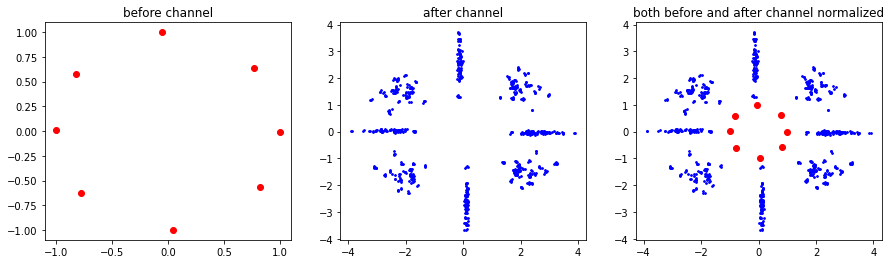

In [9]:


before_channel = Model(inputs=AE_best.input,
                                 outputs=AE_best.get_layer('normalization_layer').output)

after_channel  = Model(inputs=AE_best.input,
                                 outputs=AE_best.get_layer('channel').output)

#after_channel_normalized = Model(inputs=AE_best.input,
#                                 outputs=AE_best.get_layer('normalization_layer_at_rx').output)
    
    
bc = before_channel.predict(np.array([
    [0,0,0],
    [0,0,1],
    [0,1,0],
    [0,1,1],
    [1,0,0],
    [1,0,1],
    [1,1,0],
    [1,1,1],
    
  
  
    
]))
    

ac = after_channel.predict(x_val[:1000,:])
#acn = after_channel_normalized.predict(x_val[:1000,:])


fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].scatter(bc[:,0],bc[:,1],c="red")
ax[0].set_title("before channel")


ax[1].scatter(ac[:,0],ac[:,1],c="blue",s=3)
ax[1].set_title("after channel")


ax[2].scatter(ac[:,0],ac[:,1],c="blue",s=3)
ax[2].scatter(bc[:,0],bc[:,1],c="red") # seconded to avoid occlusion
ax[2].set_title("both before and after channel normalized")


plt.show()

In [10]:



# # Example usage:
# m = 1.5  # Shape parameter
# omega = 2.0  # Scale parameter
# num_samples = 1000
# nakagami_samples = generate_nakagami_samples((None,num_samples,),m, omega)


# # Compute the histogram
# hist, bins = np.histogram(nakagami_samples, bins=20)  # Adjust the number of bins as needed

# # Plot the histogram
# plt.figure(figsize=(8, 6))
# plt.hist(nakagami_samples, bins=20, color='blue', alpha=0.7)  # Plot the histogram bars
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram of Nakagami Samples')
# plt.grid(True)
# plt.show()

In [11]:
bc

array([[ 0.04105249, -0.99915695],
       [ 0.7694024 ,  0.63876444],
       [-0.999907  ,  0.01363654],
       [-0.8203586 ,  0.57184947],
       [ 0.8236669 , -0.56707394],
       [ 0.99990815, -0.01354835],
       [-0.7804311 , -0.62524176],
       [-0.04872756,  0.9988121 ]], dtype=float32)

In [12]:
class RicianFadingLayer(tf.keras.layers.Layer):
    def __init__(self, K, stddev, **kwargs):
        super(RicianFadingLayer, self).__init__(**kwargs)
        self.K = K  # Rician factor (K-factor)
        self.stddev = stddev  # Standard deviation of Rayleigh fading

    def call(self, inputs):
        # Generate Rayleigh fading components
#         rayleigh = tf.random.normal(tf.shape(inputs), mean=0.0, stddev=self.stddev)
        rayleigh = tf.random.rayleigh(shape=tf.shape(inputs),scale=self.stddev)
    
        # Generate line-of-sight (LOS) component
        LOS = tf.sqrt(self.K / (self.K + 1)) * tf.random.normal(tf.shape(inputs), mean=0.0, stddev=self.stddev)
        
        # Combine LOS and Rayleigh components
        rician = LOS + rayleigh
        # Apply Rician fading to input signals
        return inputs * rician

# # Example usage:
# # Create a Rician fading layer with K-factor 3 and standard deviation 0.1
# rician_layer = RicianFadingLayer(K=3, stddev=0.1)

# # Generate some input signals
# inputs = tf.random.normal((32, 64))  # Example input shape: (batch_size, input_dim)

# # Apply Rician fading to the input signals
# outputs = rician_layer(inputs)

In [13]:
preds = AE_best.predict(x_val) > 0.5
accuracy = np.mean(  preds == y_val  )


print(f"accuracy = {accuracy}")
        

25/25 [==============================] - 0s 831us/step
accuracy = 1.0


## Generating graphs


In [14]:
grid = np.zeros((len(nakagami_m_collection),len(gamma_bar_collection)))

for result in complete_results:
    grid[nakagami_m_collection.index(result["nakagami_m"]),
        gamma_bar_collection.index(result["gamma_bar"])] = result["best_block_err_rate"]


In [15]:
grid

array([[0.7725 , 0.77125, 0.77375, 0.7375 , 0.71375, 0.70875, 0.69   ,
        0.68375, 0.66125, 0.655  , 0.62   , 0.6175 , 0.58125, 0.57625,
        0.5025 , 0.53625, 0.5125 , 0.3025 , 0.35875, 0.2725 , 0.215  ,
        0.1675 , 0.1325 , 0.13   , 0.1275 , 0.14875, 0.0625 , 0.0675 ,
        0.04875, 0.08   , 0.06875, 0.0425 , 0.02875, 0.06125, 0.0225 ,
        0.02875],
       [0.71375, 0.65625, 0.655  , 0.64625, 0.6225 , 0.59   , 0.5925 ,
        0.525  , 0.50125, 0.3475 , 0.385  , 0.25875, 0.2075 , 0.155  ,
        0.115  , 0.08875, 0.055  , 0.07125, 0.025  , 0.03125, 0.0125 ,
        0.02375, 0.0225 , 0.01875, 0.0175 , 0.005  , 0.01375, 0.0025 ,
        0.00875, 0.00625, 0.     , 0.00125, 0.     , 0.     , 0.     ,
        0.     ],
       [0.66   , 0.61875, 0.59875, 0.60125, 0.58375, 0.51   , 0.49875,
        0.385  , 0.2775 , 0.2175 , 0.14375, 0.13125, 0.1025 , 0.0725 ,
        0.05125, 0.02875, 0.0275 , 0.02   , 0.01125, 0.00875, 0.0025 ,
        0.     , 0.     , 0.00125, 0.    

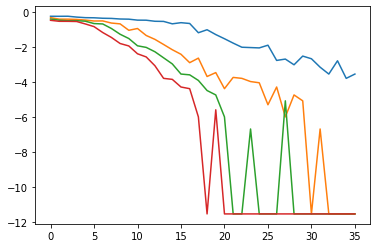

In [16]:
fig,ax  = plt.subplots(1)
for i,nakagami_m in enumerate(nakagami_m_collection):
    ax.plot(np.log(grid[i,:] + 1e-5),label=f"m = {nakagami_m}")
    
plt.show()

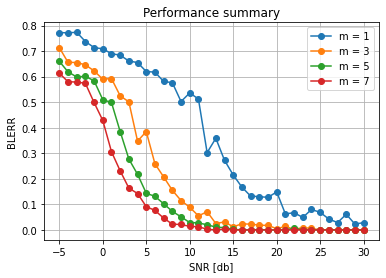

In [20]:
fig,ax  = plt.subplots(1)
for i,nakagami_m in enumerate(nakagami_m_collection):
    ax.plot(gamma_bar_collection,grid[i,:] ,label=f"m = {nakagami_m}",marker="o")
ax.legend()
ax.grid()
ax.set_title("Performance summary")
ax.set_xlabel("SNR [db]")
ax.set_ylabel("BLERR")
plt.show()